In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)
spark.sparkContext.setLogLevel("FATAL")

21/07/30 11:02:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/07/30 11:03:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
from utility import *
import pyspark.sql.functions as F
from pyspark.sql import Window

In [3]:
# Read in AP Data
df_radio24 = spark.read.csv('neighbor_data/radio_24_neighbors.csv', header=True, inferSchema=True, sep="|").limit(100000)
df_radio24 = df_radio24.filter('erm__neighbors is not Null')
df_radio24.limit(5).toPandas()

,customer,id,erm__neighbors,erm__current_channel_usage__ibss,erm__current_channel_usage__obss,erm__current_channel_usage__interference,erm__current_channel_usage__noise_floor
0,3b2ed110-59d9-11e9-b2eb-097690af9635,E43ED7D07706,"[{""bssid"":""946AB052E54C"",""ssid"":""SINGTEL-E54C""...",13,13,17,-82
1,c45af140-2b6f-11ea-925c-cb4788700b86,F08620A246F4,"[{""bssid"":""24F5A28DE78F"",""ssid"":""Linksys26584""...",13,10,14,-85
2,5a4fe380-388d-11e9-88f4-6f9acfcffd90,D463FEE9EDBE,"[{""bssid"":""F85B3BDBF297"",""ssid"":""Askey5100-ED9...",6,16,13,-78
3,e36e7de0-c350-11e9-ac21-ad5d367e4a53,488D3601041B,"[{""bssid"":""E43ED7D71342"",""ssid"":""SINGTEL-1340""...",6,9,13,-80
4,540c3bc0-fc4d-11e9-a5b9-2f5c5fe06d2e,F086202D902A,"[{""bssid"":""7829EDECB23D"",""ssid"":""SINGTEL-BB6E""...",4,12,17,-81


In [4]:
# Filter data (remove alphabetical values in numerical column)
from pyspark.sql.functions import *

df_radio24 = df_radio24.filter(~F.col('erm__current_channel_usage__ibss').rlike('[a-zA-Z]'))
df_radio24 = df_radio24.filter(~F.col('erm__current_channel_usage__obss').rlike('[a-zA-Z]'))
df_radio24 = df_radio24.filter(~F.col('erm__current_channel_usage__interference').rlike('[a-zA-Z]'))

In [5]:
getNumericalValues(df_radio24, df_radio24.columns[3:])

,summary,erm__current_channel_usage__ibss,erm__current_channel_usage__obss,erm__current_channel_usage__interference,erm__current_channel_usage__noise_floor
0,count,62500,62500,62500,62500
1,mean,11.51672,11.401024,17.863568,-80.648768
2,stddev,5.66450225765455,4.729267343567889,9.56292766378281,4.751013916661103
3,min,0,0,0,-25
4,max,9,9,99,-99


In [6]:
# Append neighbor_counts column to dataframe
from pyspark.sql.types import IntegerType
udf_get_neighbor_counts = F.udf(lambda neighbors: len(eval(neighbors)), IntegerType())
df_radio24 = df_radio24.withColumn('neighbor_counts', udf_get_neighbor_counts(F.col('erm__neighbors')))

In [7]:
# Add label
import os
path = 'Updated_WiFi_2/'
id_list = []
fileList = os.listdir(path)
for f in fileList:
    df_wifi = spark.read.csv('{}{}'.format(path, f), header=True, inferSchema=True, sep=",", nanValue='', nullValue='')
    df_wifi = df_wifi.na.replace('No', None)
    df_wifi = df_wifi.filter('customer is not Null')
    ids = list(df_wifi.select('customer').toPandas()['customer'])
    id_list.extend(ids)

In [8]:
# id_list2 = list(df_radio24.select('customer').toPandas()['customer'])
# intersection_list = list(set.intersection(set(id_list), set(id_list2)))

In [8]:
# Add label column
from pyspark.sql.types import IntegerType
def checkID(id):
    return 1 if id in id_list else 0
        
udf_get_label = F.udf(lambda id: checkID(id), IntegerType())
df_radio24 = df_radio24.withColumn('label', udf_get_label(F.col('customer')))

In [9]:
# getColumnCounts(df_radio24, 'label')

In [10]:
df_24 = df_radio24

In [11]:
cols_to_drop = ['id', 'erm__neighbors']
df_24 = df_24.drop(*cols_to_drop)
df_24.printSchema()

root
 |-- customer: string (nullable = true)
 |-- erm__current_channel_usage__ibss: string (nullable = true)
 |-- erm__current_channel_usage__obss: string (nullable = true)
 |-- erm__current_channel_usage__interference: string (nullable = true)
 |-- erm__current_channel_usage__noise_floor: string (nullable = true)
 |-- neighbor_counts: integer (nullable = true)
 |-- label: integer (nullable = true)



In [12]:
from pyspark.sql.types import IntegerType
for str_column in df_24.columns[1:-1]:
    df_24 = df_24.withColumn(str_column, F.col(str_column).cast(IntegerType()))

In [13]:
df_24.printSchema()

root
 |-- customer: string (nullable = true)
 |-- erm__current_channel_usage__ibss: integer (nullable = true)
 |-- erm__current_channel_usage__obss: integer (nullable = true)
 |-- erm__current_channel_usage__interference: integer (nullable = true)
 |-- erm__current_channel_usage__noise_floor: integer (nullable = true)
 |-- neighbor_counts: integer (nullable = true)
 |-- label: integer (nullable = true)



In [14]:
# correlatedFeatures = getCorrelation(df_24, df_24.columns, threshold=1)

In [15]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator

feature_columns = df_24.columns[1:-1]

assembler = VectorAssembler(inputCols = feature_columns, outputCol = "features")
scaler = StandardScaler(inputCol='features',outputCol='scaled_features')
minmaxScaler = MinMaxScaler(inputCol='features',outputCol='scaled_features')

kmeans = KMeans(featuresCol='scaled_features', k=2)

pipeline = Pipeline(stages=[assembler, minmaxScaler])
pipelineModel = pipeline.fit(df_24)

scaledDF = pipelineModel.transform(df_24)

kmModel = kmeans.fit(scaledDF)
results = kmModel.transform(scaledDF)

In [16]:
# results.limit(5).toPandas()

,id,erm__current_channel_usage__ibss,erm__current_channel_usage__obss,erm__current_channel_usage__interference,erm__current_channel_usage__noise_floor,neighbor_counts,label,features,scaled_features,prediction
0,E43ED7D07706,13,13,17,-82,70,0,"[13.0, 13.0, 17.0, -82.0, 70.0]","[0.16666666666666666, 0.19696969696969696, 0.1...",1
1,F08620A246F4,13,10,14,-85,40,0,"[13.0, 10.0, 14.0, -85.0, 40.0]","[0.16666666666666666, 0.15151515151515152, 0.1...",1
2,D463FEE9EDBE,6,16,13,-78,89,0,"[6.0, 16.0, 13.0, -78.0, 89.0]","[0.07692307692307693, 0.24242424242424243, 0.1...",0
3,488D3601041B,6,9,13,-80,91,0,"[6.0, 9.0, 13.0, -80.0, 91.0]","[0.07692307692307693, 0.13636363636363635, 0.1...",0
4,F086202D902A,4,12,17,-81,97,0,"[4.0, 12.0, 17.0, -81.0, 97.0]","[0.05128205128205128, 0.18181818181818182, 0.1...",0


In [17]:
# results.groupBy('prediction').count().toPandas() 

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


,prediction,count
0,1,27227
1,0,35273


In [16]:
cluster0 = filterDataFrame(results, ['prediction == 0'])
cluster1 = filterDataFrame(results, ['prediction == 1'])

In [25]:
cluster0.groupBy('label').count().toPandas() 

,label,count
0,1,835
1,0,34438


In [26]:
cluster1.groupBy('label').count().toPandas() 

,label,count
0,1,617
1,0,26610


In [19]:
getNumericalValues(cluster0, cluster0.columns[1:-3])

,summary,erm__current_channel_usage__ibss,erm__current_channel_usage__obss,erm__current_channel_usage__interference,erm__current_channel_usage__noise_floor,neighbor_counts,label
0,count,35273,35273,35273,35273,35273,35273
1,mean,12.754798287642107,13.743684971507951,22.652737221103962,-78.46446290363734,100.40464377852749,0.023672497377597596
2,stddev,5.394617776294095,3.8496333911405296,8.400437166335108,3.9763979065233537,22.801030215503932,0.15202883114480115
3,min,0,0,0,-95,8,0
4,max,45,66,99,-25,256,1


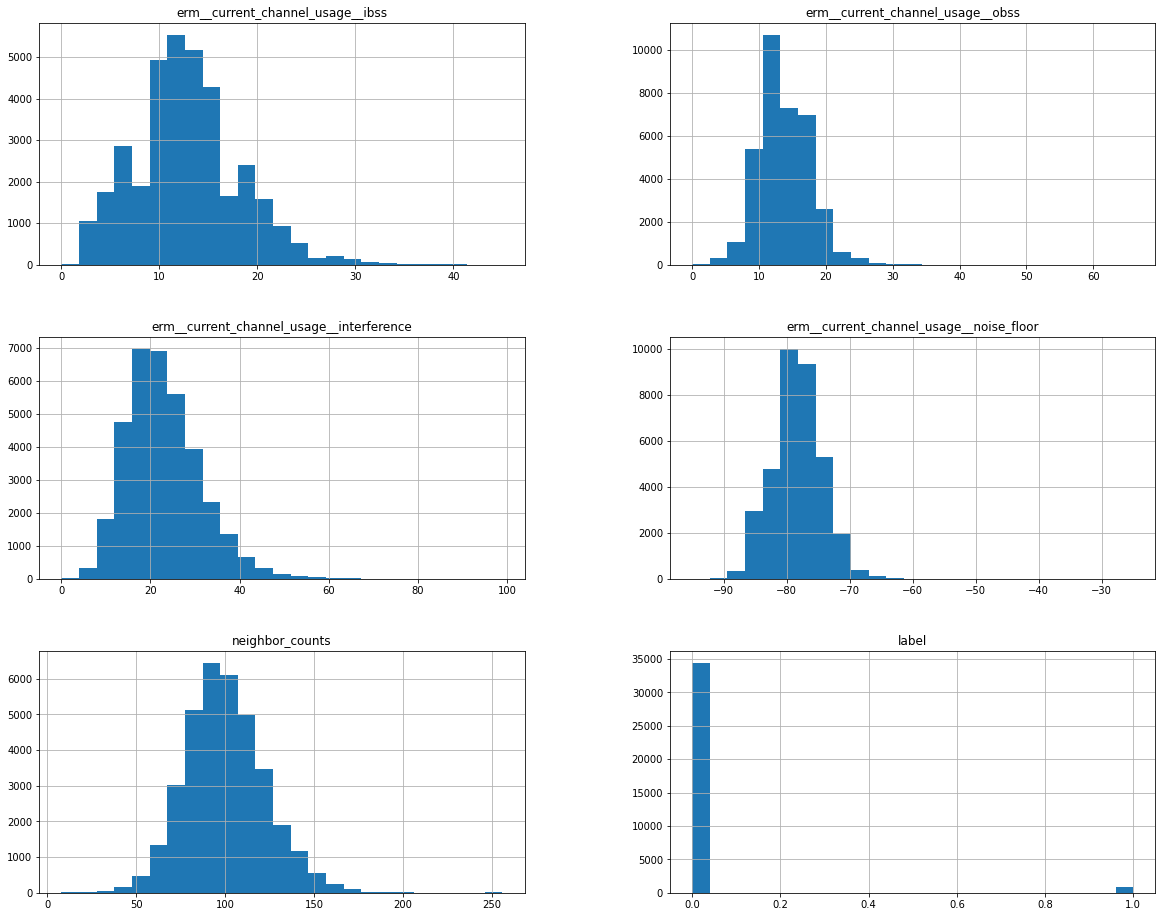

In [20]:
# graphNumericalFeatures(cluster0, cluster0.columns[1:-3])

In [21]:
getNumericalValues(cluster1, cluster1.columns[1:-3])

,summary,erm__current_channel_usage__ibss,erm__current_channel_usage__obss,erm__current_channel_usage__interference,erm__current_channel_usage__noise_floor,neighbor_counts,label
0,count,27227,27227,27227,27227,27227,27227
1,mean,9.912770411723656,8.36607044477908,11.659125133139899,-83.47856906746979,50.64549895324494,0.022661328828001617
2,stddev,5.603201347381879,3.977662856826132,7.091875214335542,4.140263909935748,21.296375373550177,0.14882407897667543
3,min,0,0,0,-99,1,0
4,max,78,45,61,-9,120,1


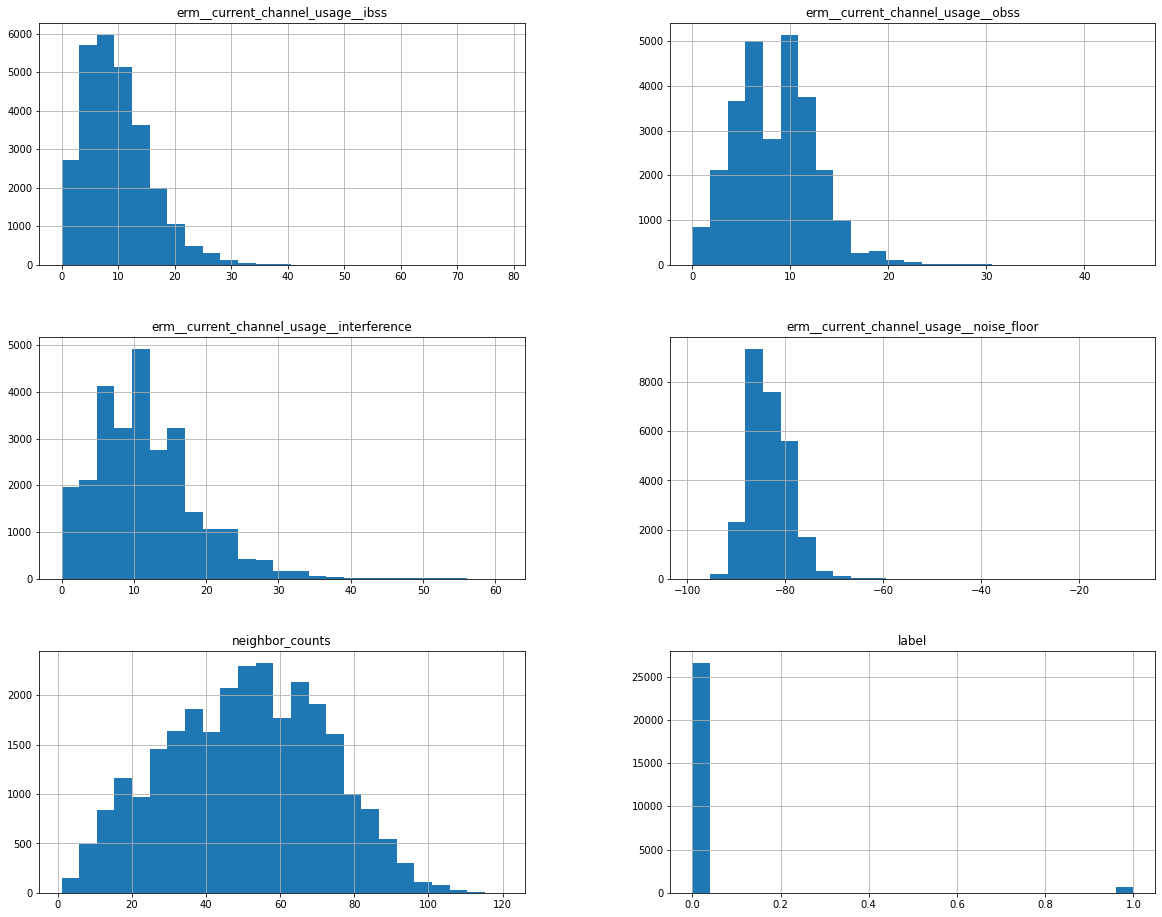

In [22]:
# graphNumericalFeatures(cluster1, cluster1.columns[1:-3])

In [19]:
pdCluster0 = cluster0.select(cluster0.columns[1:-3]).toPandas()
pdCluster1 = cluster1.select(cluster1.columns[1:-3]).toPandas()

/var/folders/yn/m0pbsyzn6kz3jdnb9f75twwr0000gp/T/ipykernel_25925/3384139739.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png') #svg


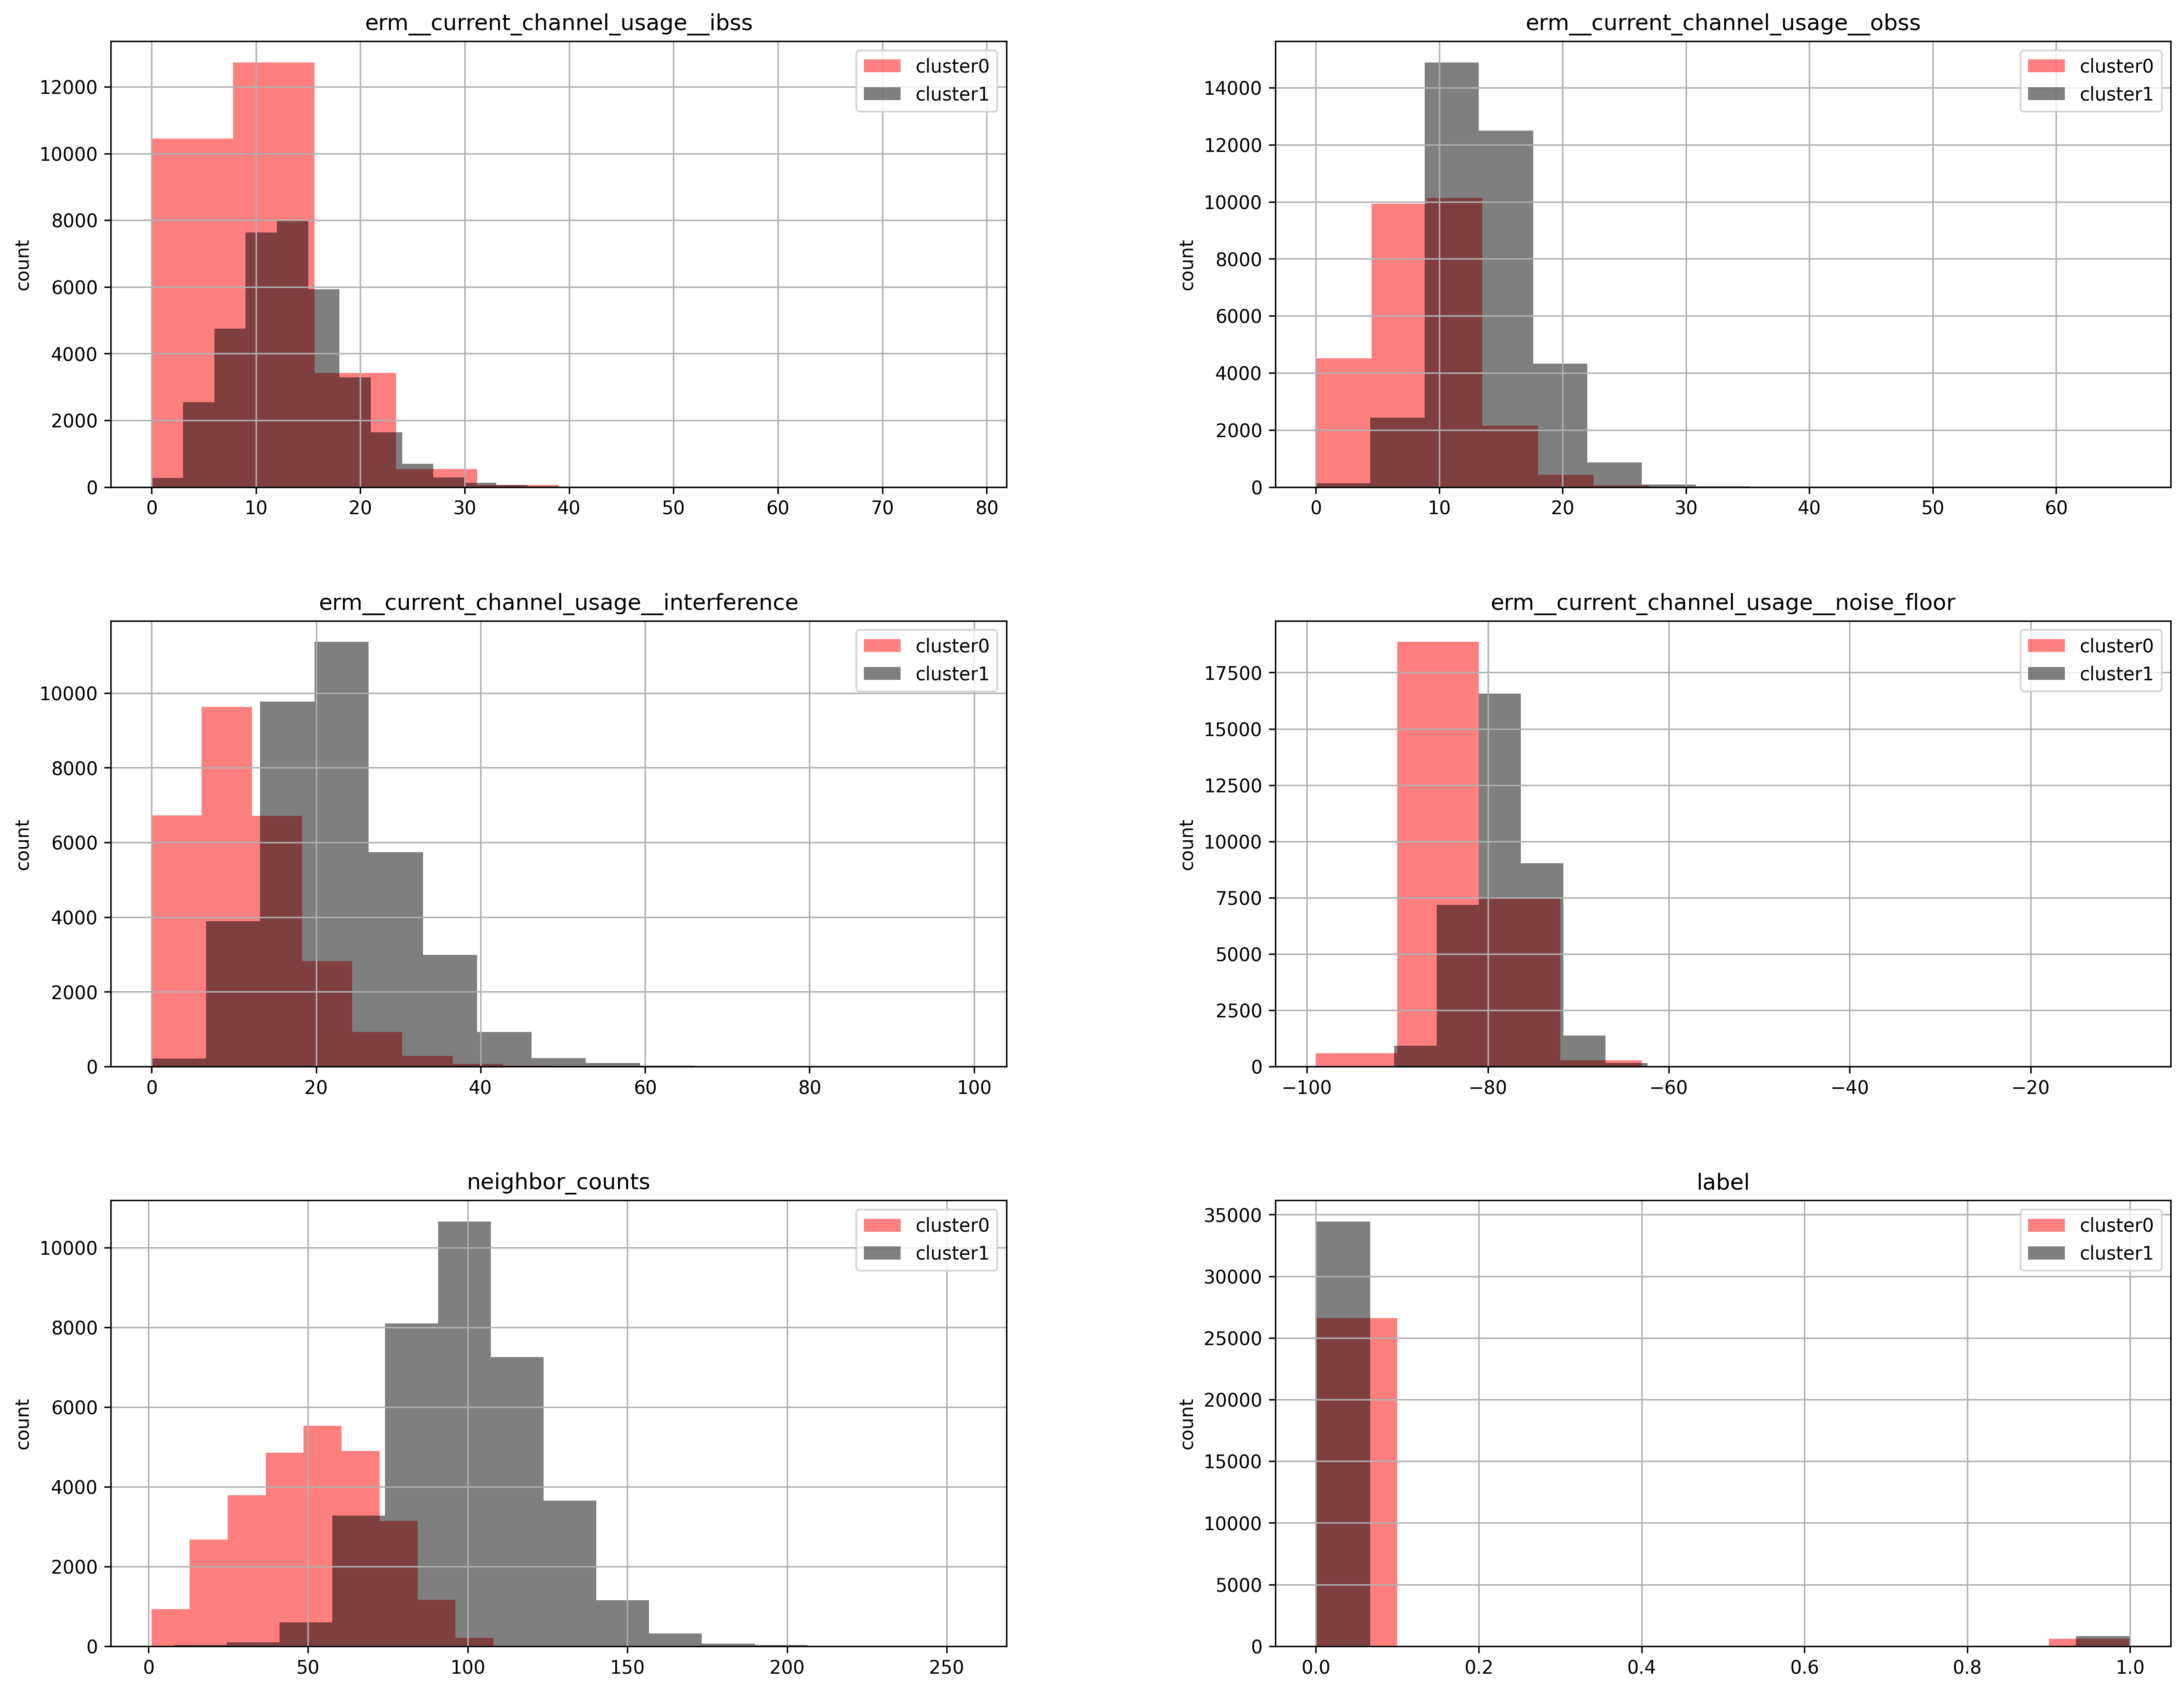

In [21]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png') #svg
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

labels = ['cluster0', 'cluster1']
colors = ['r', 'k']
alphalevel = 0.5
binSize = 15
figureSize = (20, 16)

hist = pdCluster0.hist(alpha = alphalevel, color = colors[0])
for ax, (colname, values) in zip(hist.flat, pdCluster1.iteritems()):
    values.hist(ax=ax, bins=binSize, figsize = figureSize, alpha = alphalevel, color = colors[1])
    ax.legend(labels)
    ax.set_ylabel('count')
    

In [26]:
silhouette_score = []
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaled_features', metricName='silhouette', distanceMeasure='squaredEuclidean')

for k in range(2,10):
    
    kmeans = KMeans(featuresCol='scaled_features', k=k)
    kmModel = kmeans.fit(scaledDF)
    output = kmModel.transform(scaledDF)
    
    score = evaluator.evaluate(output)
    silhouette_score.append(score)
    
    print(k, "Silhouette Score:",score)

2 Silhouette Score: 0.7348019738850334


3 Silhouette Score: 0.6028783803130301


4 Silhouette Score: 0.4890319418929865


5 Silhouette Score: 0.5075697594404374


6 Silhouette Score: 0.44196112721697434


7 Silhouette Score: 0.4380983539859836


8 Silhouette Score: 0.4539224850363054


9 Silhouette Score: 0.4258154549610285


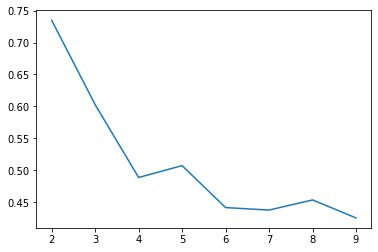

In [27]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
plt.plot(range(2,10),silhouette_score)

In [17]:
# Export Cluster Data as csv
cluster0.drop(*['features', 'scaled_features']).toPandas().to_csv('neighbors_24_cluster0.csv')
cluster1.drop(*['features', 'scaled_features']).toPandas().to_csv('neighbors_24_cluster1.csv')